In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Calibration

In [2]:
img1= cv2.imread(r"C:\Users\hritv\Desktop\Spring 23\Perception\Project 4\artroom\im0.png")
img2= cv2.imread(r"C:\Users\hritv\Desktop\Spring 23\Perception\Project 4\artroom\im1.png")
img1_gray= cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray= cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [3]:
def SIFT(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kpts,des = sift.detectAndCompute(img,None)
    return kpts,des

def key_points(kp1,kp2,img1,img2):
    mat = cv2.BFMatcher(cv2.NORM_L2, crossCheck= True)
    best_matches = mat.match(kp1[1],kp2[1])
    sort_matches = sorted(best_matches, key = lambda x:x.distance)
    p1= []
    p2= []
    for mpt in sort_matches[:1000]:
        (x1, y1) = kp1[0][mpt.queryIdx].pt
        (x2, y2) = kp2[0][mpt.trainIdx].pt
        p1.append((x1, y1))
        p2.append((x2, y2))
    return np.int32(np.array(p1)), np.int32(np.array(p2))

def F_matrix(points1, points2):
    u1=points1[:,0]
    v1=points1[:,1]
    u2=points2[:,0]
    v2=points2[:,1]
    
    A= np.empty([], dtype= np.int8)
    for i in range(len(points1)):
        a= np.array([u1[i]*u2[i],u1[i]*v2[i],u1[i],v1[i]*u2[i],v1[i]*v2[i],v1[i],u2[i],v2[i],1])
        if i == 0:
            A= np.hstack((A,a))
            A= np.delete(A,0)
        else:
            A= np.vstack((A,a))
            
    U,D,V_T= np.linalg.svd(np.dot(A.T,A))
    F_matrix= V_T.T[:,-1]
    F_matrix= np.reshape(F_matrix,(3,3))
    F_matrix= F_matrix/F_matrix[-1,-1]
    return F_matrix

In [4]:
img1_kps,img2_kps= key_points(SIFT(img1_gray),SIFT(img2_gray),img1_gray,img2_gray)

In [5]:
def RANSAC_F_matrix(kps1,kps2,iters,threshold):
    np.random.seed(111)
    inliers= 0
    best_F_matrix= None
    for i in range(iters):
        rand_pts= np.random.choice(img1_kps.shape[0],size=8,replace=False)
        F_matrix_temp= F_matrix(img1_kps[rand_pts,:],img2_kps[rand_pts,:])
        inliers_idx= []
        for j in range(img1_kps.shape[0]):
            x1= np.hstack((img1_kps[j,:], [1]))
            x2= np.hstack((img2_kps[j,:], [1]))
            d= abs(x2.T @ F_matrix_temp @ x1)
            if d < threshold:
                inliers_idx.append(j)
        if len(inliers_idx) > inliers:
            inliers= len(inliers_idx)
            best_F_matrix= F_matrix_temp
            final_inliers= inliers_idx.copy()
    return best_F_matrix, final_inliers

In [6]:
F_matrix,inliers_idx= RANSAC_F_matrix(img1_kps,img2_kps,3000,0.5)

In [7]:
F_matrix

array([[ 1.25167174e-09, -4.52032934e-06,  8.78061579e-04],
       [ 4.86596502e-06,  1.64721186e-07, -4.24830715e-02],
       [-1.77389961e-03,  4.17432001e-02,  1.00000000e+00]])

In [8]:
len(inliers_idx)

850

In [9]:
K1= np.array([[1733.74,0,792.27], [0,1733.74,541.89], [0,0,1]])
K2= np.array([[1733.74,0,792.27], [0,1733.74,541.89], [0,0,1]])
E_matrix= K1.T @ F_matrix @ K2

In [10]:
U,D,V_T= np.linalg.svd(E_matrix)
W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)
W

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [11]:
C1= U[:,2]
C2= -U[:,2]
R1= U @ W @ V_T
R2= U @ W.T @ V_T

# Rectification


In [12]:
pts1=img1_kps[inliers_idx,:]
pts2=img2_kps[inliers_idx,:]

In [13]:
def drawlines(img1, img2, lines, pts1, pts2):
    r,c = img1.shape
    img1color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x1, y1 = map(int, [0, -r[2]/r[1]])
        x2, y2 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(img1color, (x1, y1), (x2, y2), color, 1)
        img1color = cv2.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv2.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

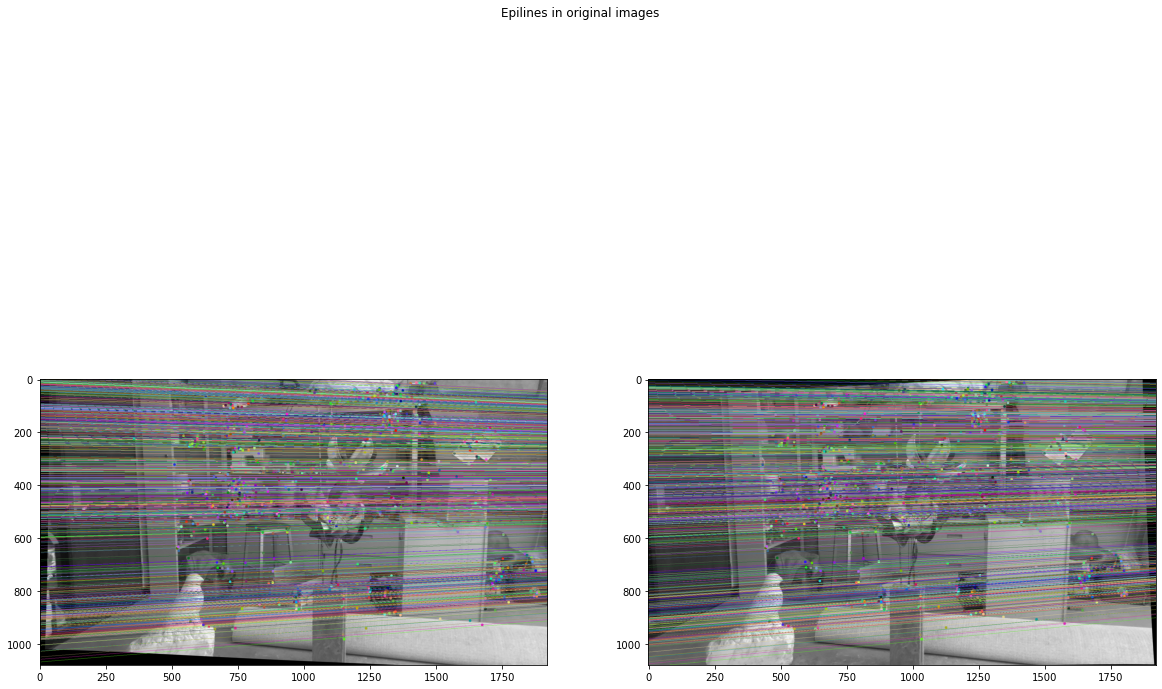

In [14]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1_gray, img2_gray, lines1, pts1, pts2)
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2_gray, img1_gray, lines2, pts2, pts1)

plt.rcParams["figure.figsize"]= (20,15)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in original images")
plt.show()

In [15]:
h1, w1, c = img1.shape
h2, w2, c = img2.shape
_,H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F_matrix, imgSize=(w1, h1))

In [16]:
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
img1_rectified= cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2GRAY)
img2_rectified= cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2GRAY)

cv2.imwrite("rectified_1.png", img1_rectified)
cv2.imwrite("rectified_2.png", img2_rectified)

True

In [37]:
rec_pts1= []
rec_pts2= []
for i in range(len(pts1)):
    X1= np.hstack((pts1[i], [1]))
    X2= np.hstack((pts2[i], [1]))
    res1= H1 @ X1
    res2= H2 @ X2
    rec_pts1.append((res1[0],res1[1]))
    rec_pts2.append((res2[0],res2[1]))
    
rec_pts1= np.int32(np.array(rec_pts1))
rec_pts2= np.int32(np.array(rec_pts2))

[[ 2.1785114e-02 -9.9976265e-01  1.4191649e+01]
 [ 2.0967601e-02 -9.9978018e-01  2.1567602e+01]
 [ 2.1547930e-02 -9.9976784e-01  1.5849545e+01]
 ...
 [ 2.1623861e-02 -9.9976617e-01  1.5348638e+01]
 [ 2.4419339e-02 -9.9970180e-01 -1.0151399e+01]
 [ 2.3738427e-02 -9.9971819e-01 -4.2053399e+00]]


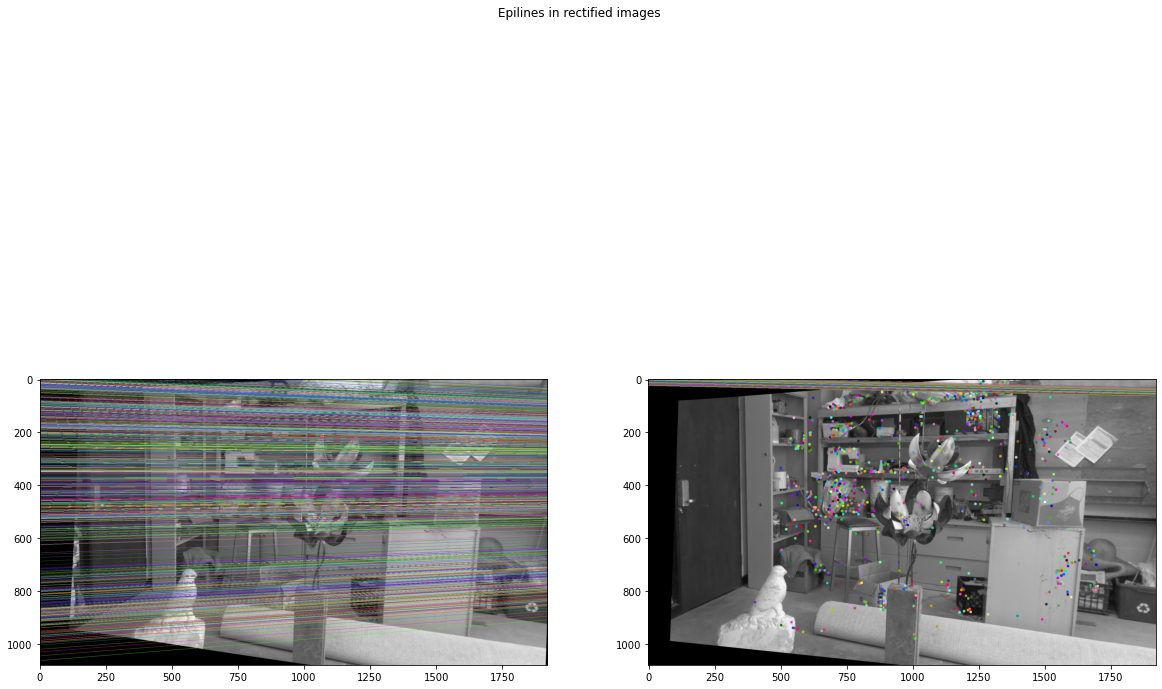

In [44]:
img1_rec= cv2.cvtColor(cv2.imread('rectified_1.png'),cv2.COLOR_BGR2GRAY)
img2_rec= cv2.cvtColor(cv2.imread('rectified_2.png'),cv2.COLOR_BGR2GRAY)

lines1_rec = cv2.computeCorrespondEpilines(rec_pts2.reshape(-1, 1, 2), 2, F_matrix)
lines1_rec = lines1_rec.reshape(-1, 3)
img5_rec, img6_rec = drawlines(img1_rec, img2_rec, lines1_rec, rec_pts1, rec_pts2)
lines2_rec = cv2.computeCorrespondEpilines(rec_pts1.reshape(-1, 1, 2), 1, F_matrix)
lines2_rec = lines2_rec.reshape(-1, 3)
img3_rec, img4_rec = drawlines(img2_rec, img1_rec, lines2_rec, rec_pts2, rec_pts1)
plt.rcParams["figure.figsize"]= (20,15)
plt.subplot(121), plt.imshow(img5_rec)
plt.subplot(122), plt.imshow(img3_rec)
plt.suptitle("Epilines in rectified images")
plt.show()

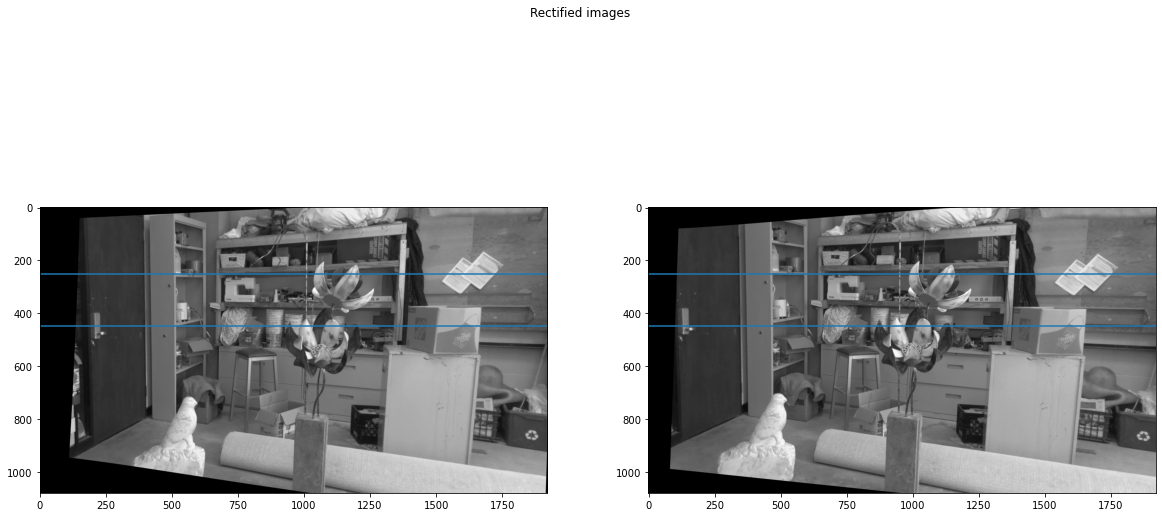

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

# Correspondence

In [18]:
import numpy as np
from PIL import Image

def stereo_match(left_img, right_img, kernel, max_offset):
    # Load in both images, assumed to be RGBA 8bit per channel images
    left_img = Image.open(left_img).convert('L')
    left = np.asarray(left_img)
    right_img = Image.open(right_img).convert('L')
    right = np.asarray(right_img)    
    w, h = left_img.size  # assume that both images are same size   
    
    # Depth (or disparity) map
    depth = np.zeros((w, h), np.uint8)
    depth.shape = h, w
       
    kernel_half = int(kernel / 2)
    offset_adjust = 255 / max_offset  # this is used to map depth map output to 0-255 range
      
    for y in range(kernel_half, h - kernel_half):              
        print("\rProcessing.. %d%% complete"%(y / (h - kernel_half) * 100), end="", flush=True)        
        
        for x in range(kernel_half, w - kernel_half):
            best_offset = 0
            prev_ssd = 65534
            
            for offset in range(max_offset):               
                ssd = 0
                ssd_temp = 0                            
                
#                 for v in range(-kernel_half, kernel_half):
#                     for u in range(-kernel_half, kernel_half):
#                         # iteratively sum the sum of squared differences value for this block
#                         # left[] and right[] are arrays of uint8, so converting them to int saves
#                         # potential overflow
#                         ssd_temp = int(left[y+v, x+u]) - int(right[y+v, (x+u) - offset])  
#                         ssd += ssd_temp * ssd_temp              
                
                diff_intensity = left[y-kernel_half:y+kernel_half+1, x-kernel_half:x+kernel_half+1] - right[y-kernel_half:y+kernel_half+1, x-kernel_half-offset:x+kernel_half-offset+1]
                ssd_intensity = np.square(diff_intensity)
                ssd_total = np.sum(ssd_intensity)    
                if ssd < prev_ssd:
                    prev_ssd = ssd
                    best_offset = offset
                            
            # set depth output for this x,y location to the best match
            depth[y, x] = best_offset * offset_adjust
                                
    # Convert to PIL and save it
    Image.fromarray(depth).save('depth.png')
    return depth

if __name__ == '__main__':
    disparity_map= stereo_match("rectified_1.png", "rectified_2.png", 9, 60)  # 6x6 local search kernel, 30 pixel search range


Processing.. 0% complete

ValueError: operands could not be broadcast together with shapes (9,9) (9,0) 